In [1]:
%pylab inline
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 15
import hmf
import haloSim
import simutil
import cosmology
import maputil as mutilities
from configparser import ConfigParser
from pixel3D import cartesianGrid3D
cosmo=cosmology.Cosmo(h=1.,omega_m=0.315)
from scipy.interpolate import griddata
if False:
    figMsDir='/work/xiangchong.li/superonionGW/code/massMap_Private/doc/paper_ms_method_HSCY1/'
else:
    figMsDir='/home/xiangchong/Documents/Docs/massMap/paper_HSC2021/'
cmap=plt.get_cmap('tab20')

Populating the interactive namespace from numpy and matplotlib


In [14]:
configName  =   'wrkDir/config-nl15.ini'
parser      =   ConfigParser()
parser.read(configName)

NameError: name 'ConfigParser' is not defined

In [2]:
hmfmod='Tinker08'#'ST'#
mf = hmf.MassFunction(Mmin=14.7,Mmax=15.2,dlog10m=0.008,hmf_model=hmfmod,takahashi=True,sigma_8=0.811,n=0.965)
mf.update(cosmo_params={"Om0":0.315,"H0":67.4})
print(mf.cosmo)
print(mf.hmf_model)

FlatLambdaCDM(name="Planck15", H0=67.4 km / (Mpc s), Om0=0.315, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)
<class 'hmf.mass_function.fitting_functions.Tinker08'>


<ipython-input-6-0f6698f97fb5>:25: RuntimeWarning: divide by zero encountered in log10
  plt.step((mf.m[1:]+mf.m[:-1])/2.,np.log10(y/nscale),where='mid',color=cmap(iz),ls='--')


2547.2398218985973
33025.417203308534
64486.88675351263
78236.38660270214
74608.30045352364
60864.64303394013
44236.84984188926


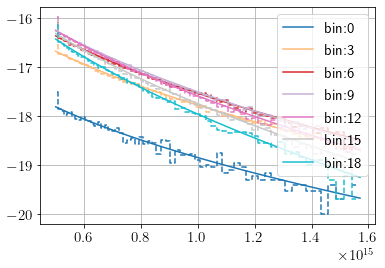

In [6]:
plt.close()
nsamp=25
zbound=np.linspace(0.01,0.85,nsamp+1)
zmin=zbound[:-1]
zmax=zbound[1:]
zave=(zmin+zmax)/2.
nscale=1e20

zlist=[]
mlist=[]
nlist=[]
for iz in range(0,20,3):
    z=zave[iz]
    mf.update(z=z)
    v=cosmo.V(zmin[iz],zmax[iz])*np.pi**2./180.**2./4./np.pi
    mass_func = mf.dndm*v
    m = mf.m
    msample=[]
    sAll=np.sum(mass_func)
    for i in range(int(sAll*nscale)):
        msample.append(simutil.mcSample(m,mass_func))
    msample=np.array(msample)
    y=np.histogram(msample,bins=m)[0]
    plt.plot(m,np.log10(mass_func),label='bin:%d' %iz,color=cmap(iz))
    plt.step((mf.m[1:]+mf.m[:-1])/2.,np.log10(y/nscale),where='mid',color=cmap(iz),ls='--')
    print(sAll*nscale)
plt.legend()
plt.grid()

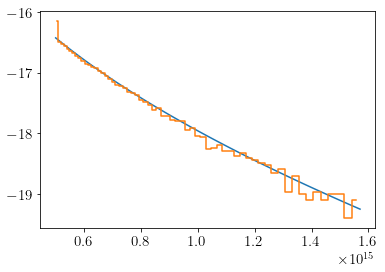

In [10]:
msample=[]
sAll=np.sum(mass_func)
for i in range(int(sAll*nscale)):
    msample.append(simutil.mcSample(m,mass_func))
msample=np.array(msample)
y=np.histogram(msample,bins=m)[0]
plt.plot(m,np.log10(mass_func/np.sum(mass_func)*sAll),label='bin:%d' %iz)
plt.step((mf.m[1:]+mf.m[:-1])/2.,np.log10(y/np.sum(y)*sAll),where='mid')

In [74]:
hfou=haloSim.haloCS02SigmaAtom(3.5,64,nx=64,c=9.,smooth_scale=1.5,fou=False,lnorm=1)

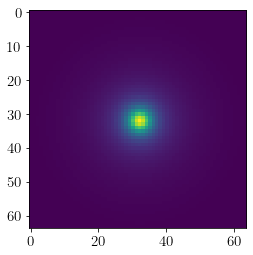

In [75]:
imshow(np.fft.fftshift(hfou))

0.2933080468239622
0.9999999999999998
0.15937554676697757
1.0
0.10871553260104437
1.0


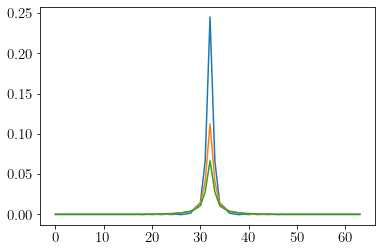

In [80]:
plt.close()
for rs in [0.5,1.,1.5]:
    hfou=haloSim.haloCS02SigmaAtom(rs,64,nx=64,c=9.,smooth_scale=-1,fou=False,lnorm=1)
    plt.plot(np.fft.fftshift(hfou)[32])
    print(np.sqrt(np.sum(hfou**2.)))
    print(np.sum(hfou**1.))

/home/xiangchong/work/ana/lsstsw/miniconda/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/xiangchong/work/ana/lsstsw/miniconda/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/xiangchong/work/ana/lsstsw/miniconda/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


0.16487565864560383
1.0
0.11175592265909234
1.0
0.08434636203080643
1.0


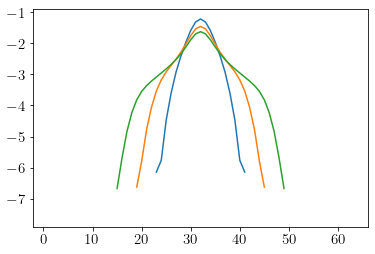

In [3]:
plt.close()
for rs in [0.5,1.,1.5]:
    hfou=haloSim.haloCS02SigmaAtom(rs,64,nx=64,c=9.,smooth_scale=1.2,fou=False,lnorm=1)
    plt.plot(np.log10(np.fft.fftshift(hfou)[32]))
    print(np.sqrt(np.sum(hfou**2.)))
    print(np.sum(hfou**1.))